In [101]:
import deepSI
from deepSI.systems.System import System, System_Deriv, System_data
import numpy as np
from matplotlib import pyplot as plt
import torch

import quadprog

In [106]:
def control_cal_multi(A,B,C,n_think_ahead,x_current,x_target,umin=-1,umax=1): #class possible for better precomputing
    #x+ = A x + B u + C
    #xn = [A^3, A^2, A^1, I]*[x,C,C,C] + [A^2*B,A*B,B]*[u0,u1,u2]
    #xn =           D                  + E*[u0,u1,u2]
    # -1<=ui<=1
    # b = 
    nu = B.shape[1]
    nx = A.shape[0]

    
    Ccon = []
    bcon = []
    Dlist = []
    Elist = []
    
    for k in range(1,n_think_ahead+1):
        
        E = []
        D = np.zeros((nx,),dtype=float)
        Amult = np.eye(nx,dtype=float)
        for i in range(k):
            D += Amult@C
            E.append(Amult@B)
            Amult = Amult@A
        E = E[::-1]
        for z in range(n_think_ahead-k): #is this correct?
            E.append(np.zeros((nx,nu)))
        E = np.concatenate(E,1)
        D += Amult@x_current #x_current?
        Dlist.append(D)
        Elist.append(E)
    

    umin, umax = np.array(umin), np.array(umax)
    umin = [umin]*(n_think_ahead*nu) if umin.ndim==0 else umin
    umax = [umax]*(n_think_ahead*nu) if umax.ndim==0 else umax
    
    for i,(umin,umax) in enumerate(zip(umin,umax)):
        Cline = np.zeros((nu*n_think_ahead))
        Cline[i] = 1
        Ccon.append(Cline)
        bcon.append(umin)
        Cline = np.zeros((nu*n_think_ahead))
        Cline[i] = -1
        Ccon.append(Cline)
        bcon.append(-umax)
        
        
    Ccon = np.array(Ccon).T
    bcon = np.array(bcon,dtype=float)

    # A@A@A@A@x0 + A@A@A@C + A@A@C + A@C+C
#     print([Ek.shape for Ek in Elist])
    a = np.sum([(x_target.T-Dk.T)@Ek for Ek,Dk in zip(Elist,Dlist)],axis=0)
    G = np.sum([Ek.T@Ek for Ek in Elist],axis=0)
#     print(G.shape,a.shape)
    u = quadprog.solve_qp(G, a, Ccon, bcon, 0)[0]
    
    return u[:nu]

In [4]:
# fit_sys.save_system('encoder_visual_sys')
fit_sys = deepSI.load_system('encoder_visual_sys_long')

In [162]:
from deepSI.systems import ball_in_box_video_system
class ball_in_box_video_system_side_start(ball_in_box_video_system):
    def reset(self):
        self.x = [0.8,0.8,0,0] #[x,y,vx,vy]
        return self.h(self.x) #return position 
    #save state?
class ball_in_box_video_system_other_side_start(ball_in_box_video_system):
    def reset(self):
        self.x = [0.2,0.2,0,0] #[x,y,vx,vy]
        return self.h(self.x) #return position 

In [173]:
sys_other_side = ball_in_box_video_system_other_side_start()
sys_other_side.reset()
sys_other_side.deriv(sys_other_side.x, [-0.46875,-0.46875])

[0, 0, -1.3877787807814457e-17, -1.3877787807814457e-17]

In [180]:
f = lambda x,u: fit_sys.fn(torch.cat((x[None,:],u[None,:]),dim=1))[0]  #assume torch arrays


u0 = np.array([-0.46875,-0.46875])
sys_side2 = ball_in_box_video_system_side_start()

#calculate target state:
sys_target = ball_in_box_video_system_other_side_start()
exp_target = System_data(u=[u0]*100)
out_target = sys_target.apply_experiment(exp_target)
out_target_normed = fit_sys.norm.transform(out_target)
with torch.no_grad():
    ynow, k0 = fit_sys.init_state(out_target_normed)
    out_target_state = fit_sys.state[0]

target_x = out_target_state.detach().numpy()

#init state encoder
sys_side = ball_in_box_video_system_side_start() #side system
exp_side = System_data(u=[-u0]*100)
out_side = sys_side.apply_experiment(exp) #better exp possible
out_side_normed = fit_sys.norm.transform(out_side) #norm
with torch.no_grad():
    ynow, k0 = fit_sys.init_state(out_side_normed) #apply normed to fit_sys

#init state real system
sys_side2 = ball_in_box_video_system_side_start()
Y_uncontrolled = []
Y_controlled = []

Y_controlled.append(sys_side.reset())
for i in range(k0):
    Y_controlled.append(sys_side.step(-u0))
Y_uncontrolled.append(sys_side2.reset())
for i in range(k0):
    Y_uncontrolled.append(sys_side2.step(-u0))
target_x_real = np.array([0.2,0.2,0,0])


unow = torch.tensor([0.,0.],requires_grad=True) #point
umin = (sys.action_space.low-fit_sys.norm.u0)/fit_sys.norm.ustd
umax = (sys.action_space.high-fit_sys.norm.u0)/fit_sys.norm.ustd
n_think_ahead=4

Xhist_controlled = []
Xhist_uncontrolled = []

for time in range(50):
    #calculate A,B C
    # fit_sys.fn() #nx+nu
    
    #calculate dfdx and dfdu
    xnow = fit_sys.state[0].clone().detach() #get current state
    xnow.requires_grad=True
    xnext = f(xnow,unow)
    dfdx, dfdu = [np.array([np.array(dfdxi,dtype=float) for dfdxi in dfdx]) for dfdx in list(zip(*[torch.autograd.grad(xi,(xnow,unow),retain_graph=True) for xi in xnext]))]

    #contruct A,B,C: x approx A@x+B@u+C
    A = dfdx
    B = dfdu
    C = np.array(xnext.detach().numpy()-dfdx@xnow.detach().numpy(),dtype=float)

    #solve QP control problem
    unext = control_cal_multi(A,B,C,n_think_ahead=n_think_ahead,x_current=xnow.detach().numpy(),x_target=target_x,umin=umin,umax=umax)
    unext_real = unext*fit_sys.norm.ustd+fit_sys.norm.u0 #convert to real u
    

    fit_sys.step(unext) #apply control on encoder
    Y_controlled.append(sys_side.step(unext_real)) #apply control side encoder
    Y_uncontrolled.append(sys_side2.step(u0))
    
    diff_controlled = sys_side.x-target_x_real
    diff_uncontrolled = sys_side2.x-target_x_real
    Xhist_controlled.append(diff_controlled)
    Xhist_uncontrolled.append(diff_uncontrolled)

# dfdx_list = []
# dfdu_list = []
# for xi in xnext:
#     dfdx,dfdu = torch.autograd.grad(xnext[1],(xnow,unow))
#     dfdx_list.append()
Xhist_controlled = np.array(Xhist_controlled)
Xhist_uncontrolled = np.array(Xhist_uncontrolled)

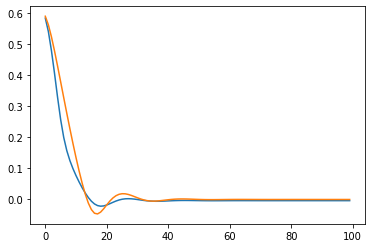

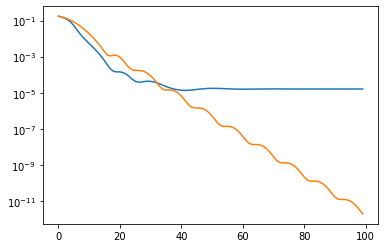

In [177]:
plt.plot(Xhist_controlled[:,0])
plt.plot(Xhist_uncontrolled[:,0])
plt.show()
plt.semilogy(np.mean(Xhist_controlled**2,axis=1))
plt.semilogy(np.mean(Xhist_uncontrolled**2,axis=1))
plt.show()

In [183]:
sys_data_both = System_data(y=np.concatenate((Y_controlled,Y_uncontrolled),axis=1))

sys_data_controlled = System_data(y=Y_controlled)
sys_data_uncontrolled = System_data(y=Y_uncontrolled)

In [184]:
sys_data_both.to_video('side-to-side')

In [109]:
umin,umax

(array([-1.7257385, -1.7265723], dtype=float32),
 array([1.735482 , 1.7402879], dtype=float32))